# Concatenated Network - MakeMore pt.3 (21/04/2023)

We are now ready to move on to Multilayer Perceptrons models: in order to do it we are going to reproduce the results of an "old" paper.

We are going to see the procedure of **embedding**, which is one of the most powerful tools in Neural Networks architectures: basically, we choose to encode (randomly at the beginning) our words into vectors in a euclidean space of a certain dimension (there are no general rules to choose such dimension), and see how with training our network clusterizes automatically the words.
In our case we are actually going to see it working on just characters instead of words.
As a matter of fact, we are going to consider a $3-$gram approximation of our language model.

We have as input the characters at time $t-1$, $t-2$ and $t-3$ (we are considering tri-grams) which get embedded by a matrix $C$ in a $30-$dimensional vector as chosen by the authors of the paper.
Then we put together these three $30$-dimensional vectors to get a $90$-dimensional one.
We feed this vector to an intermediate layer with a nonlinear transformation ($\tanh$).
The output of such "hidden" layer gets then fed to a last layer which linearly transforms it by $\hat{W} \cdot \vec{x} + \hat{B}$.

We will see that there are many parameters in such system: the coefficients in the embedding matrix $C$ and the matrix $W$, which will change with training in order to minimize the loss, but also some numbers which we a priori choose, which define the structure of our Multi-Layer Perceptron.
For example, the dimension of the embedding, or the gradient descent rate.
These are the so-called **hyperparameters**.

In [2]:
# https://youtu.be/P6sfmUTpUmc
# https://github.com/karpathy/makemore

In [3]:
# we now want to dig more into neural activity and learning to understand the RNN and LSTM architecture and properties...

import random
import torch
import torch.nn.functional as  F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [5]:
# read in all the words
random.seed(158)
words = open("data/nomi_italiani.txt", "r").read().splitlines()
random.shuffle(words)
words[0:8]

['argento',
 'giovannino',
 'licurga',
 'elvira',
 'marena',
 'sirio',
 'emilia',
 'bisio']

In [6]:
print(len(words))

9105


In [7]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))

stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
# new
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}
28


In [8]:
# build the dataset

block_size = (
    # context length: how many characters do we take to predict the next one ...
    3
)


def build_dataset(words):
    X, Y = [], []  # input & label

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #  print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  # shift: crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [9]:
import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([58867, 3]) torch.Size([58867])
torch.Size([7404, 3]) torch.Size([7404])
torch.Size([7372, 3]) torch.Size([7372])


We now construct the first layer: the input of such layer will have dimension $3 \cdot 2 = 6$, i.e. the multiplied dimension of the $n$-gram and the embedding dimension.
We will consider $100$ neurons (another hyperparameter).

In [10]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(123456780)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)  # neurons
b1 = torch.randn(n_hidden, generator=g)  # bias
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # number of parameter in total...
for p in parameters:
    p.requires_grad = True

12108


Now we would like to compute the product $emb \cdot W1 + b1$.
But $emb$ has a different dimension (or shape) with regard to $W1$: we need to **concatenate** the elements of $emb$ in order to get the same dimension.
Now, there would be many ways to do this: with PyTorch we have the function $cat$ (together with $unbind$) which could do the work for us... but there is actually a much less time-costing way. 

As a matter of fact, PyTorch has a built-in method $view$ which re-organizes the elements of a tensor in the shape we choose: and it does this operation just (roughly) re-arranging the allocated memory for each term, and not allocating new memory: therefore this is far more efficient than using other PyTorch functions.
This is what we are going to use.

In [11]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward bass
    emb = C[Xb]  # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats

    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}:{loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000:25.2234
  10000/ 200000:2.2865
  20000/ 200000:2.1045
  30000/ 200000:2.1319
  40000/ 200000:1.8164
  50000/ 200000:1.6172
  60000/ 200000:1.8491
  70000/ 200000:1.9464
  80000/ 200000:1.9799
  90000/ 200000:2.3608
 100000/ 200000:1.3078
 110000/ 200000:1.9567
 120000/ 200000:1.5188
 130000/ 200000:1.7088
 140000/ 200000:1.6152
 150000/ 200000:2.0892
 160000/ 200000:1.2948
 170000/ 200000:1.3657
 180000/ 200000:1.7789
 190000/ 200000:1.5764


In [12]:
print(-torch.tensor(1 / 28).log())

tensor(3.3322)


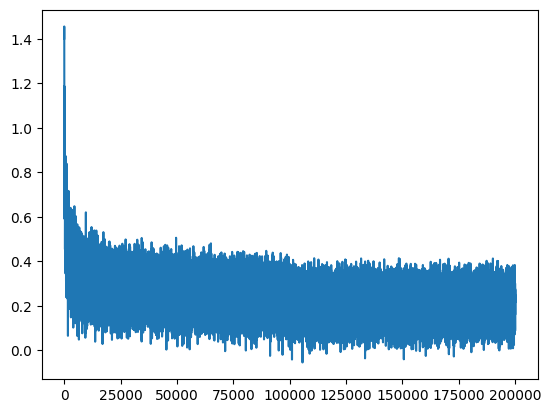

In [14]:
plt.plot(lossi)

In [15]:
# this decorator disables gradient tracking....discuss in class....
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # (N,block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N,block_size*n_embd)
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer (N, h_hidden)
    logits = h @ W2 + b2  # output layer (N, vocab_size)
    loss = F.cross_entropy(logits, y)  # loss function
    print(split, loss.item())

In [16]:
split_loss("train")
split_loss("val")

train 1.6465035676956177
val 1.8481979370117188


In [17]:
# sampling from the model.....

g = torch.Generator().manual_seed(12345678 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,n_embed)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribuion
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word

albo.
giovanno.
rizio.
siside.
polina.
gio.
assimo.
cecchiarosinda.
benuartinaippirenziana.
peppio.
abdocchia.
bella.
benio.
moheo.
lauretilla.
rinieronino.
filosca.
esaro.
euto.
giliana.


In [21]:
# let us focus on the last layer ....logits and then softmax

logits = torch.randn(4) * 100
# logits = view(2, 2, 2, 20)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print("logits:", logits)
print("probs:", probs)
print("loss:", loss)

logits: tensor([-14.4960, -31.7004, 124.3944, 179.8049])
probs: tensor([0.0000e+00, 0.0000e+00, 8.6204e-25, 1.0000e+00])
loss: tensor(55.4105)


In [22]:
# back to our examples and look at the logit just after the first pass and understand normalization....


# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(123456780)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)  # *0.20
b1 = torch.randn(n_hidden, generator=g)  # *0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g)  # *0.01
b2 = torch.randn(vocab_size, generator=g)  # *0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # number of parameter in total...
for p in parameters:
    p.requires_grad = True

12108


In [23]:
# same optimization as last time...try, look at logits then go up and change W2 and b2 normalization.....
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward bass
    emb = C[Xb]  # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats

    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}:{loss.item():.4f}")
    lossi.append(loss.log10().item())
    break

      0/ 200000:25.2234


In [26]:
print(
    logits[1]
)  # confidently wrong... but with weigth is better... 'squashing down the neurons...'

tensor([ 10.6530,  -7.2423,  31.2924, -15.8263,   7.0554,  -0.8957,  10.4593,
          8.9841,  13.3143,  -2.6116,  14.7497,  17.5647,  17.0676,   1.1002,
         14.7031, -13.5323, -19.1125, -21.7921,  21.1479,   8.6535,   7.4713,
         -3.2913,   3.2052,   1.8503,  12.2664,  -3.8606,   3.1228,   4.6715],
       grad_fn=<SelectBackward0>)


In [ ]:
# Exercise: try the followi ng normalization, train , evaluate and sample the MLP

In [29]:
# Now we focus on the first layer (show pict): h & hpreact

# remember to intialize and run again

# look at the +- 1 in h
print(h.shape)

torch.Size([32, 200])


In [28]:
print(len(h.view(-1).tolist()))  # 32*200

6400


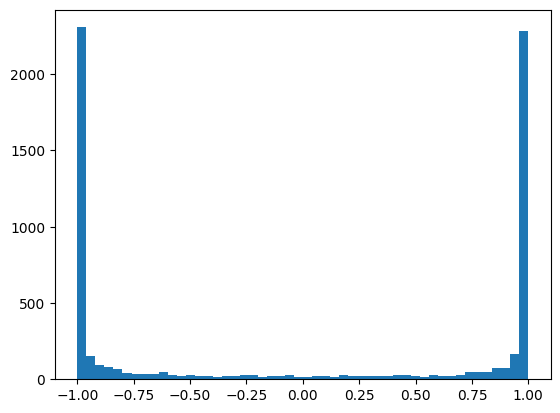

In [30]:
plt.hist(h.view(-1).tolist(), 50)
# a lot of neurons  are ' saturated'

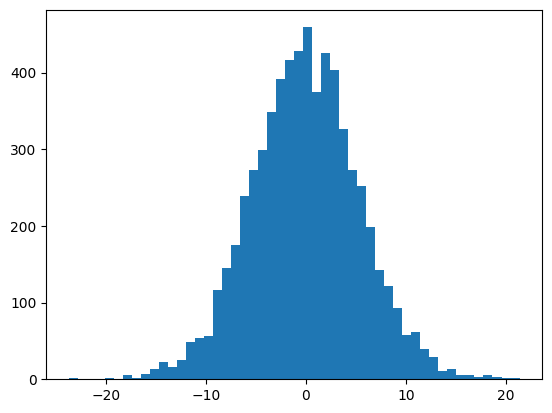

In [31]:
# now look at the "broad" shape of the 'hpreact' distribution.....and this is bad for learning....we want 'normality' for our brain...
# tgh'(x)= (1-tgh(x)^2).... saturation bring to vanish gradient...no learning...
plt.hist(hpreact.view(-1).tolist(), 50)
# a lot of neurons  are ' saturated'

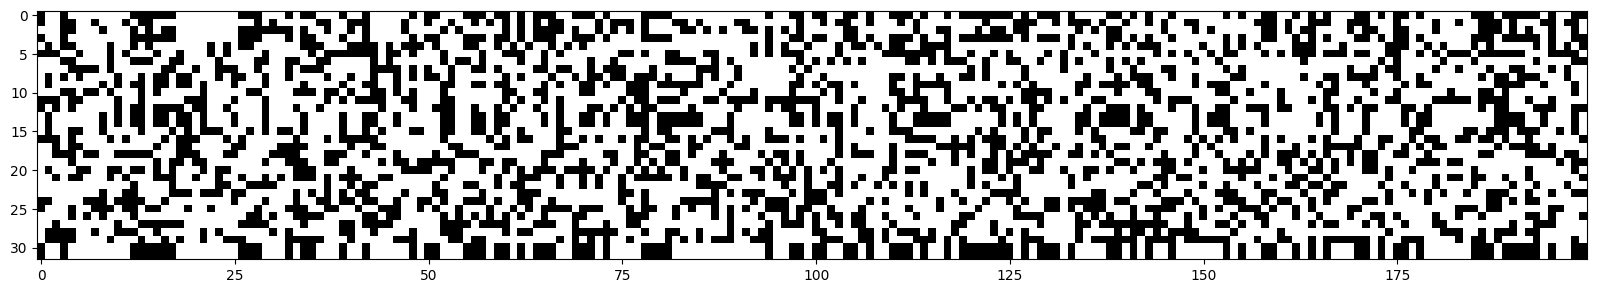

In [33]:
# looking for dead neurons....comment other Activation Functions..... go back weigth the first layer and try again...

plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

torch.Size([1000, 200])
tensor(0.0148) tensor(0.9958)
tensor(-0.0002) tensor(3.1940)


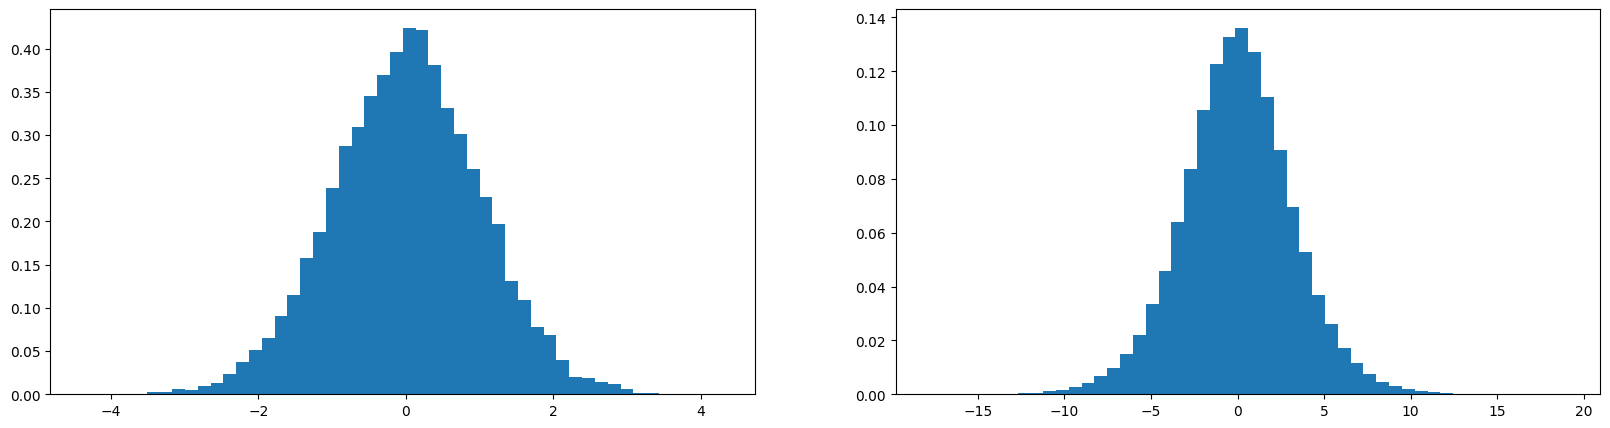

In [34]:
# why we do not to have to worry too much about inizialization....bach normalization..
# since 2015
# https://arxiv.org/abs/1502.03167
# if the problems are fluctuations and saturations (discuss in class)...then just gaussain normalize at each layer...
# simple as that !!!...and normalizing is differentiable !!....

x = torch.randn(1000, 10)
w = torch.randn(10, 200)  # *.2 #*1/10**0.5
y = x @ w
print(y.shape)
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)